# Model Iteration 2

## Sources

### The source I draw inspiration from are as followings:

   DataQuest Kaggle module called improving your submission (https://www.dataquest.io/mission/75/improving-your-submission)
 

## Previous Implementation from model iteration 1

In [95]:
import pandas
# We can use the pandas library in python to read in the csv file.
# This creates a pandas dataframe and assigns it to the titanic variable.
titanic = pandas.read_csv("./titanic data/train.csv")
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
titanic["Embarked"] = titanic["Embarked"].fillna('S')
titanic.loc[titanic["Embarked"] == "S", "Embarked"]=0
titanic.loc[titanic["Embarked"] == "C", "Embarked"]=1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"]=2


## Inspired Implementation from source

In [96]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [97]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        # print (title_search)
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v


# Add in the title column.
titanic["Title"] = titles

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import KFold
# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title"]],
    [linear_model.LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
#     for i in range(2):
#         test_predictions += full_test_predictions[i]
#     test_predictions = test_predictions/2
    
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.821548821549


/home/zhecan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [99]:
titanic_test = pandas.read_csv("./titanic data/test.csv")

titanic_test = pandas.read_csv("./titanic data/test.csv")
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna('S')

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"]=0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"]=1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"]=2
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())


In [100]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))
        

In [101]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn import linear_model
# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title"]],
    [linear_model.LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]


predictions = []
full_test_predictions = []

for alg, predictors in algorithms:
    # Train the algorithm using all the training data
    alg.fit(titanic[predictors], titanic["Survived"])

    # Make predictions using the test set.
    test_predictions = alg.predict(titanic_test[predictors])
    
    full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2

    
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
test_predictions[test_predictions <= .5] = 0
test_predictions[test_predictions > .5] = 1
predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)



In [102]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

print submission.shape
submission.to_csv('model2_first.csv', index=False)

(418, 2)


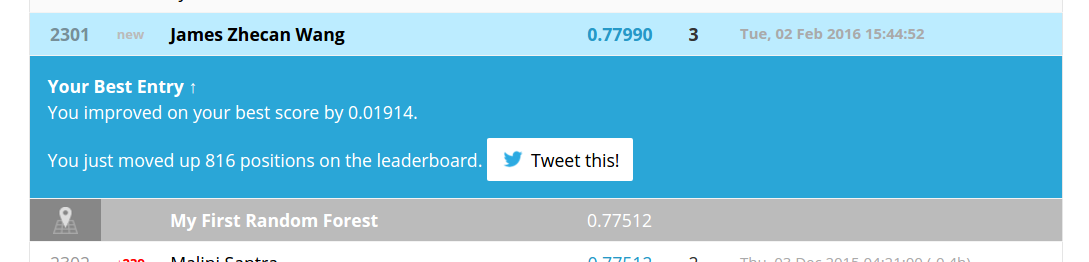

In [103]:
# ![alt text](./Screenshot\ from\ 2016-01-27\ 13\:30\:41.png)
from IPython.display import Image
Image(filename= "model2_first.png") 

## Additional ideas of my own

1. Using grid search to tune the hyper parameters for the models
2. Adding more models to the combination group

### Grid Search

In [104]:
import re
import numpy as np
from decimal import *
from sklearn import svm
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import grid_search
from sklearn.grid_search import ParameterGrid




if __name__ == '__main__':

      
#     svr1 = linear_model.SGDClassifier()
#     parameters1 = {'loss':['log', 'modified_huber']
#     , 'penalty': ['none', 'l2', 'l1', 'elasticnet']
#     ,  'fit_intercept':[True, False], 'n_iter': np.arange(1,20, 3)
#     , 'shuffle':[True, False]
#     , 'l1_ratio':np.linspace(0, 1, num = 10)
#     , 'alpha': [0.01, 0.001, 0.0001, 0.00001, 0.000001]
#     , 'epsilon': np.linspace(0, 1, 10)
#     , 'verbose': np.linspace(0, 1, 10)
#     }


#     svr2 = MultinomialNB()
#     parameters2 = {'alpha':np.linspace(0,2,100), 'fit_prior': [True, False]
#     }

#     svr3 = BernoulliNB()
#     parameters3 = {'alpha': np.linspace(0,2,20), 'binarize': np.linspace(-1,1,20), 'fit_prior': [True, False]
#     }




    clf = grid_search.GridSearchCV(svr1, parameters1)

    clf.fit(titanic[predictors].iloc[train,:], train_target)

    print "Model Trained"
    print clf.best_estimator_.get_params()


    


NameError: name 'svr1' is not defined

### Adding more models

In [105]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier


# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
predictors = ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]
algorithms = [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), linear_model.LogisticRegression(random_state=1), linear_model.SGDClassifier(warm_start = False, loss = 'modified_huber', n_jobs = 1
                , eta0 = 0.0, verbose = 0.1111111111111111, shuffle = True, fit_intercept = True, epsilon = 0.44444444444444442
                , average = False, n_iter = 4, penalty = 'l2', power_t = 0.5, random_state = None, l1_ratio = 0.22222222222222221
                , alpha = 1e-05, learning_rate = 'optimal', class_weight = None ), MultinomialNB(alpha=0.0, fit_prior=False, class_prior=None), BernoulliNB(binarize=0.89473684210526305, alpha=0.10526315789473684, fit_prior=True, class_prior=None), 
             RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for i in range(6):
        alg = algorithms[i]
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
        
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
#     for i in range(len(full_test_predictions)):
#         test_predictions += full_test_predictions[i]
#     test_predictions = test_predictions/(len(full_test_predictions))

#     test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
#     test_predictions = (full_test_predictions[0] + full_test_predictions[1]+ full_test_predictions[2]) / 3
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]+full_test_predictions[2]+full_test_predictions[3]+full_test_predictions[4] + full_test_predictions[5]) / 6

    
    
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.795735129068


/home/zhecan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [112]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier


# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
predictors = ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]
algorithms = [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), linear_model.LogisticRegression(random_state=1), linear_model.SGDClassifier(warm_start = False, loss = 'modified_huber', n_jobs = 1
                , eta0 = 0.0, verbose = 0.1111111111111111, shuffle = True, fit_intercept = True, epsilon = 0.44444444444444442
                , average = False, n_iter = 4, penalty = 'l2', power_t = 0.5, random_state = None, l1_ratio = 0.22222222222222221
                , alpha = 1e-05, learning_rate = 'optimal', class_weight = None ), MultinomialNB(alpha=0.0, fit_prior=False, class_prior=None), BernoulliNB(binarize=0.89473684210526305, alpha=0.10526315789473684, fit_prior=True, class_prior=None), 
             RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)]

predictions = []

full_test_predictions = []
    # Make predictions for each algorithm on each fold
for i in range(6):
    alg = algorithms[i]
    # Fit the algorithm on the training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Select and predict on the test fold.  
    # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
    test_predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_test_predictions.append(test_predictions)
        
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
test_predictions = (full_test_predictions[0] + full_test_predictions[1]+full_test_predictions[2]+full_test_predictions[3]+full_test_predictions[4] + full_test_predictions[5]) / 6

    
    
# Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
test_predictions[test_predictions <= .5] = 0
test_predictions[test_predictions > .5] = 1
predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)
# print predictions.shape

(418,)


In [111]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv('model2_second.csv', index=False)

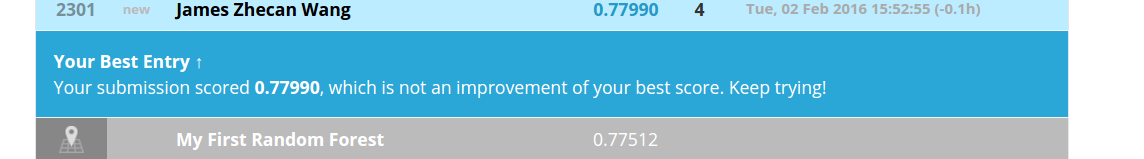

In [113]:
# ![alt text](./Screenshot\ from\ 2016-01-27\ 13\:30\:41.png)
from IPython.display import Image
Image(filename= "model2_second.png") 

The scoare does not get better. Some of the reasons may be that the data set is relatively quite small and some of the models cannot really be trained to make predictions accurately without large data sets. Also, there is not a proper weight system for combing the models together since some of the models can be much more accurate than the others.

## Future Explorations

    1. Create an optimize script with a reasonable loss function to calculate the best weights combination for different models.
    2. Generate more new features by combining existing features